In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import time

2025-06-12 23:04:16.649044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749769456.848518      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749769456.902330      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1. Problem/Data Description

The dataset originates from the Kaggle competition "Getting Started - GAN," which focuses on building Generative Adversarial Networks (GANs).

**Objective**: Develop and train a GAN model capable of learning Monet's artistic style and transferring it onto new input photos.

**Data Description**

    *The dataset consists of 2 types of images
        300 Real Monet paintings
        7000 photos that we are to convert to a style of a Monet painting
    * Each image is of 256 by 256 pixels
    * Each image contains 3 color channels: Red, Green & Blue



In [3]:
# Load the dataset
MONET_PATH = "/kaggle/input/im-something-of-a-painter-myself-dataset/monet_jpg"
PHOTO_PATH = "/kaggle/input/im-something-of-a-painter-myself-dataset/photo_jpg"

print('Number of images in Monet directory: ', len(os.listdir(MONET_PATH)))
print('Number of images in Photo directory: ', len(os.listdir(PHOTO_PATH)))

Number of images in Monet directory:  300
Number of images in Photo directory:  7038


In [4]:
# Load Images

IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

def get_dataset(image_dir):
    file_paths = tf.data.Dataset.list_files(str(image_dir + '/*.jpg'))
    dataset = file_paths.map(load_image, num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

monet_ds = get_dataset(MONET_PATH)
photo_ds = get_dataset(PHOTO_PATH)


I0000 00:00:1749769470.543112      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## 2.Exploratory Data Analysis

In this section, I carried out initial Exploratory Data Analysis (EDA) on the photo_jpg dataset to assess its suitability for training a GAN. I began by visualizing a grid of sample images from the training pipeline, which revealed high-quality, diverse, and photo-realistic content — an encouraging sign for generative modeling.

Additionally, I plotted RGB histograms for both the photo and Monet datasets. The real photos showed sharp peaks near zero, reflecting higher contrast and shadow detail, while Monet paintings exhibited smoother, more evenly distributed colors, especially in the blue and green channels — highlighting the stylistic divergence the GAN will need to learn.

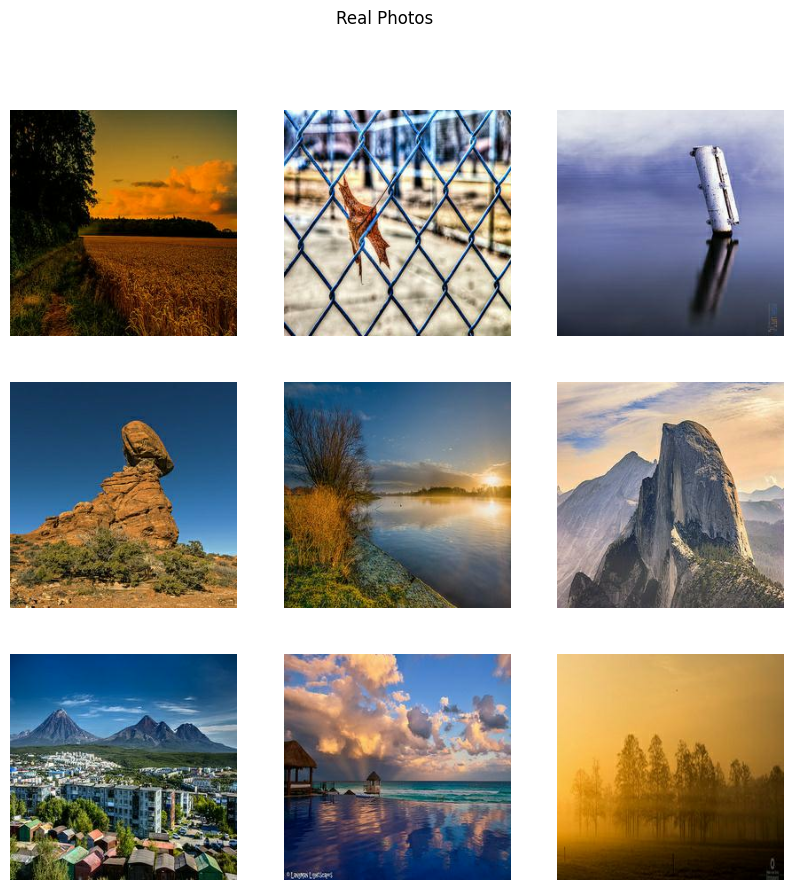

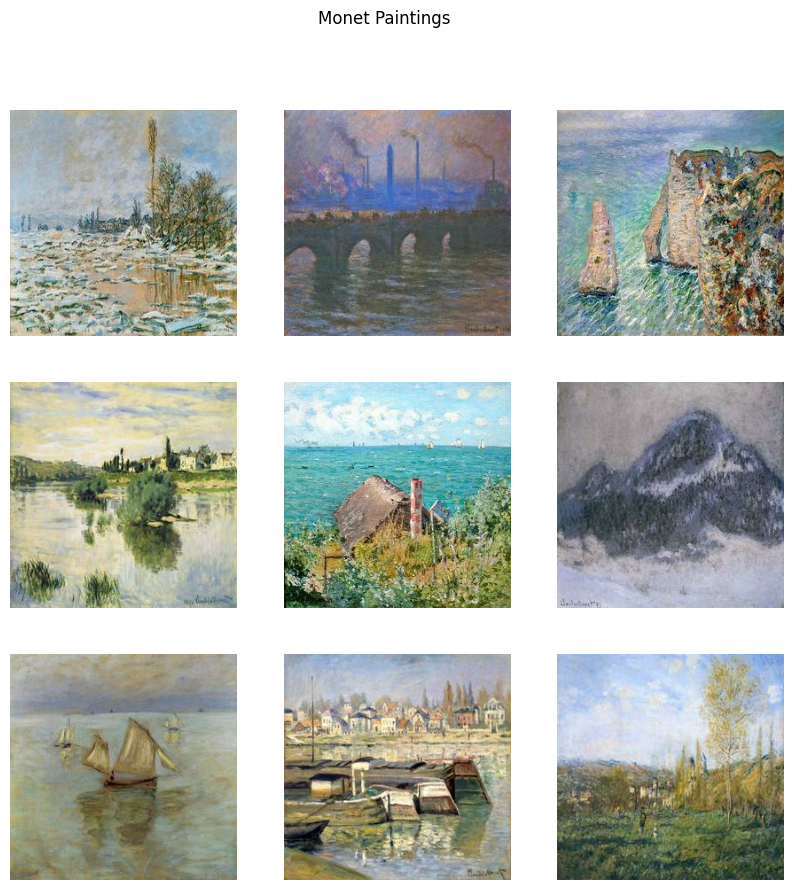

In [5]:
def show_sample(dataset, title):
    sample_images = next(iter(dataset))
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        img = (sample_images[i] + 1) / 2  # Rescale from [-1, 1] to [0, 1]
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_sample(photo_ds, "Real Photos")
show_sample(monet_ds, "Monet Paintings")


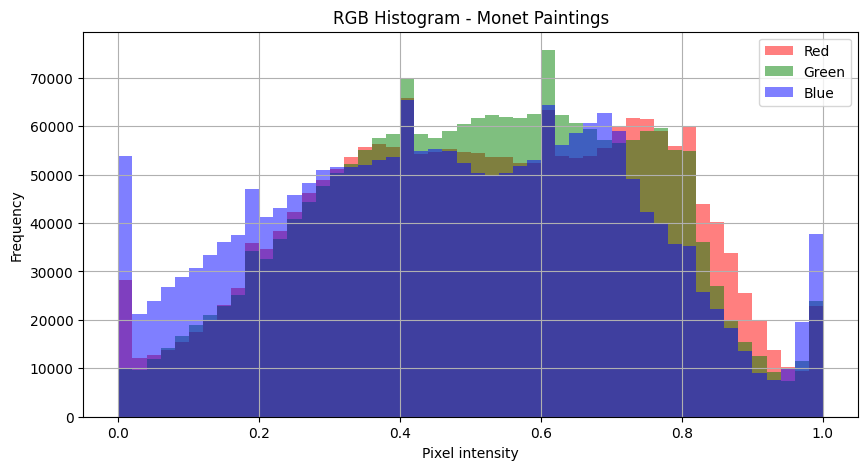

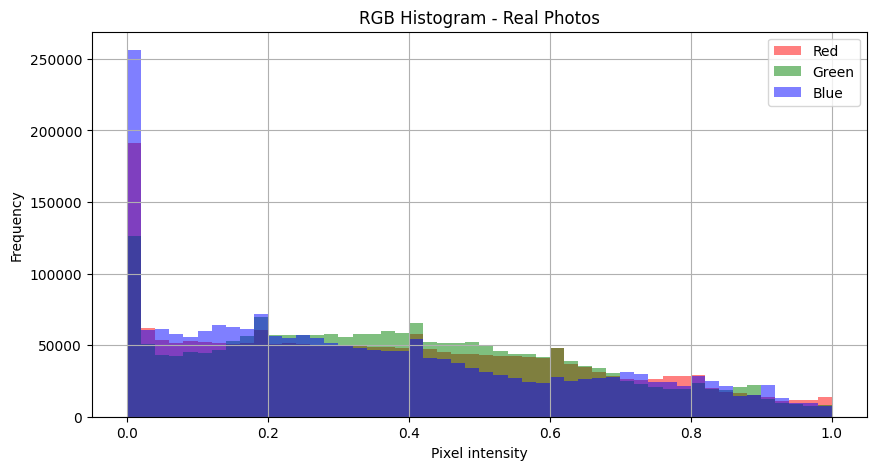

In [6]:

def plot_rgb_histogram(dataset, title):
    batch = next(iter(dataset))
    batch = (batch + 1) / 2  
    batch = batch.numpy()

    red_vals = batch[:, :, :, 0].flatten()
    green_vals = batch[:, :, :, 1].flatten()
    blue_vals = batch[:, :, :, 2].flatten()

    plt.figure(figsize=(10, 5))
    plt.hist(red_vals, bins=50, color='red', alpha=0.5, label='Red')
    plt.hist(green_vals, bins=50, color='green', alpha=0.5, label='Green')
    plt.hist(blue_vals, bins=50, color='blue', alpha=0.5, label='Blue')
    plt.title(f'RGB Histogram - {title}')
    plt.xlabel("Pixel intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rgb_histogram(monet_ds, "Monet Paintings")
plot_rgb_histogram(photo_ds, "Real Photos")


## 3. Data Preprocessing

In the data preprocessing stage, we loaded Monet paintings and real photos, resized them to 256×256 pixels, and normalized pixel values to the [−1,1][−1,1] range — a standard requirement for GAN training. We used TensorFlow's data pipeline to efficiently process and batch the images. For training, we added random horizontal flips to introduce data augmentation. The resulting datasets (monet_ds and photo_ds) are now ready for feeding into the GAN models.

In [7]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 1  # CycleGAN paper used batch size = 1
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image
# Data Augmentation

def preprocess_train_image(file_path):
    image = preprocess_image(file_path)
    image = tf.image.random_flip_left_right(image)
    return image

# tf.data Datasets

def build_dataset(directory, training=True):
    files = tf.data.Dataset.list_files(directory + "/*.jpg")
    ds = files.map(preprocess_train_image if training else preprocess_image,
                   num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

monet_ds = build_dataset(MONET_PATH, training=True)
photo_ds = build_dataset(PHOTO_PATH, training=True)



## 4. Model Architecture 

The CycleGAN model architecture is well-suited for the dataset at hand, which contains unpaired images of Monet-style paintings and real-world photos. Unlike traditional GANs that require paired training data, CycleGAN learns to translate images between two domains without one-to-one correspondence. It achieves this using two generator networks and two discriminator networks: one generator translates photos to Monet-style paintings, and the other performs the reverse translation. Each generator is based on a ResNet-style architecture, which captures both low-level textures and high-level structural features effectively through the use of residual blocks. These residual connections help maintain the content of the original image while allowing stylistic transformation, which is ideal for artistic style transfer tasks like this one.

The discriminators, implemented as PatchGANs, classify small patches (rather than the whole image) as real or fake, enabling them to focus on local texture and style consistency — a key aspect in distinguishing Monet-style brushwork from photographic detail. Moreover, the use of cycle consistency loss ensures that the translated image can be mapped back to its original form, preserving semantic content. Identity loss further helps maintain the structure and color integrity when inputs are already in the target domain. Together, these components make CycleGAN a powerful and flexible model for style transfer on this unpaired image dataset.

In [8]:
import tensorflow as tf
from tensorflow.keras import layers

def resnet_block(x, filters):
    init = x
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    return layers.add([x, init])

def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Downsampling
    x = layers.Conv2D(64, 7, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual blocks
    for _ in range(9):
        x = resnet_block(x, 256)

    # Upsampling
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Output layer
    x = layers.Conv2D(3, 7, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs, x, name="Generator")


In [9]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = layers.Input(shape=[256, 256, 3])

    x = layers.Conv2D(64, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(inputs)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(512, 4, strides=1, padding='same',
                      kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(1, 4, strides=1, padding='same',
                      kernel_initializer=initializer)(x)

    return tf.keras.Model(inputs, x, name="Discriminator")


In [10]:
# Generators
G = Generator()  # Photo → Monet
F = Generator()  # Monet → Photo

# Discriminators
D_X = Discriminator()  # For photos
D_Y = Discriminator()  # For Monets


**Loss functions**

In [11]:
LAMBDA = 10  # Weight for cycle consistency loss

# Binary Crossentropy Loss (used for adversarial)
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [12]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)


In [13]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return 0.5 * (real_loss + generated_loss)


In [14]:
def calc_cycle_loss(real_image, cycled_image):
    return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))


In [15]:
def identity_loss(real_image, same_image):
    return 0.5 * LAMBDA * tf.reduce_mean(tf.abs(real_image - same_image))


In [16]:
# Optimizers for generators
generator_G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)  # Photo → Monet
generator_F_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)  # Monet → Photo

# Optimizers for discriminators
discriminator_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)  # Photo Discriminator
discriminator_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)  # Monet Discriminator


**Train the CycleGAN model**

We are now ready train the models. Below are the steps I followed to train the model.

* Defined the training step using @tf.function to perform forward passes, calculate all losses (adversarial, cycle, identity), and apply gradients for generators and discriminators.


* Initialized and configured TensorFlow checkpoints to save model weights and optimizer states after each epoch.Restored the latest checkpoint (if available) to support resuming interrupted training.

 * Created an epoch-level training loop that:

    Iterates over batches from photo_ds and monet_ds

    Calls the train_step() on each batch

    Generates and displays a Monet-style image from a sample photo after each epoch

    Saves a checkpoint at the end of each epoch

* Trained the model for 190 epochs initially and prepared to run the final 10 epochs separately for visualization and analysis.

In [17]:

# === Sample image for visual feedback ===
sample_photo = next(iter(photo_ds))
sample_photo_input = sample_photo[0:1] 

# === Generate and display images ===
def generate_images(model, input_image, epoch):
    prediction = model(input_image, training=False)
    prediction = (prediction + 1) / 2.0
    input_image = (input_image + 1) / 2.0

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title("Input Photo")
    plt.imshow(input_image[0])
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Generated Monet")
    plt.imshow(prediction[0])
    plt.axis("off")

    plt.suptitle(f"Epoch {epoch}")
    plt.show()

In [18]:
# === Checkpoint setup ===
checkpoint_dir = './checkpoints/train'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_G=G,
                                 generator_F=F,
                                 discriminator_X=D_X,
                                 discriminator_Y=D_Y,
                                 generator_G_optimizer=generator_G_optimizer,
                                 generator_F_optimizer=generator_F_optimizer,
                                 discriminator_X_optimizer=discriminator_X_optimizer,
                                 discriminator_Y_optimizer=discriminator_Y_optimizer)

In [19]:
# === Restore latest checkpoint if available ===
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [20]:
# === Training step ===
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = G(real_x, training=True)
        fake_x = F(real_y, training=True)

        cycled_x = F(fake_y, training=True)
        cycled_y = G(fake_x, training=True)

        same_x = F(real_x, training=True)
        same_y = G(real_y, training=True)

        disc_real_x = D_X(real_x, training=True)
        disc_real_y = D_Y(real_y, training=True)
        disc_fake_x = D_X(fake_x, training=True)
        disc_fake_y = D_Y(fake_y, training=True)

        gen_G_loss = generator_loss(disc_fake_y)
        gen_F_loss = generator_loss(disc_fake_x)

        cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        id_loss_G = identity_loss(real_y, same_y)
        id_loss_F = identity_loss(real_x, same_x)

        total_G_loss = gen_G_loss + cycle_loss + id_loss_G
        total_F_loss = gen_F_loss + cycle_loss + id_loss_F

        disc_X_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_Y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    generator_G_optimizer.apply_gradients(zip(tape.gradient(total_G_loss, G.trainable_variables), G.trainable_variables))
    generator_F_optimizer.apply_gradients(zip(tape.gradient(total_F_loss, F.trainable_variables), F.trainable_variables))
    discriminator_X_optimizer.apply_gradients(zip(tape.gradient(disc_X_loss, D_X.trainable_variables), D_X.trainable_variables))
    discriminator_Y_optimizer.apply_gradients(zip(tape.gradient(disc_Y_loss, D_Y.trainable_variables), D_Y.trainable_variables))

Epoch 191/200


I0000 00:00:1749769563.421835      58 cuda_dnn.cc:529] Loaded cuDNN version 90300


  Step 0 completed
  Step 100 completed
  Step 200 completed


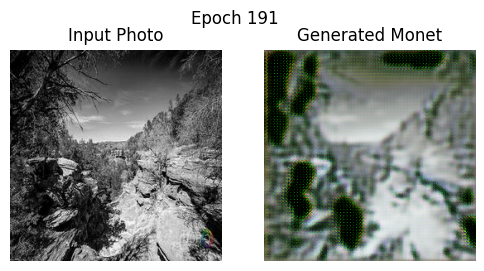

Time for epoch 191: 204.46 sec

Epoch 192/200
  Step 0 completed
  Step 100 completed
  Step 200 completed


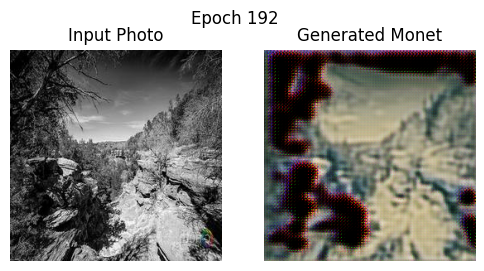

Time for epoch 192: 126.19 sec

Epoch 193/200
  Step 0 completed
  Step 100 completed
  Step 200 completed


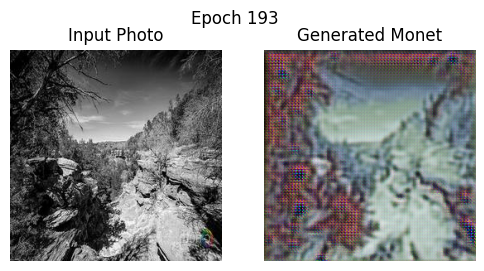

Time for epoch 193: 126.00 sec

Epoch 194/200
  Step 0 completed
  Step 100 completed
  Step 200 completed


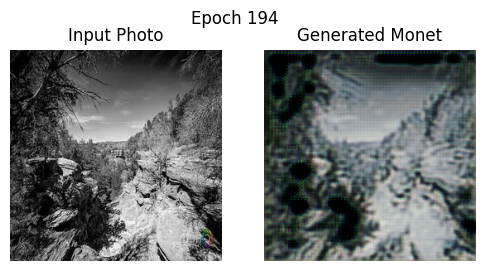

Time for epoch 194: 125.89 sec

Epoch 195/200
  Step 0 completed
  Step 100 completed
  Step 200 completed


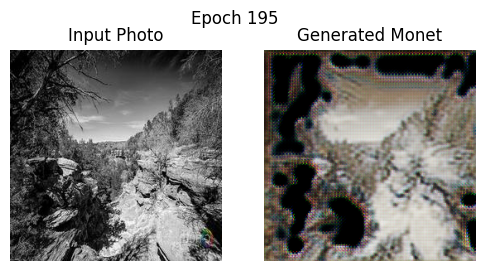

Time for epoch 195: 125.65 sec

Epoch 196/200
  Step 0 completed
  Step 100 completed
  Step 200 completed


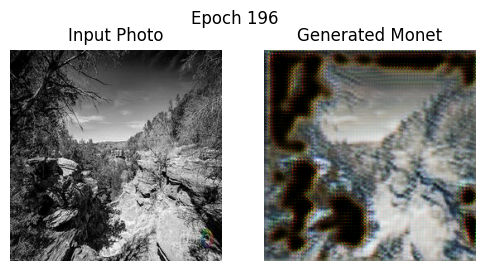

Time for epoch 196: 125.81 sec

Epoch 197/200
  Step 0 completed
  Step 100 completed
  Step 200 completed


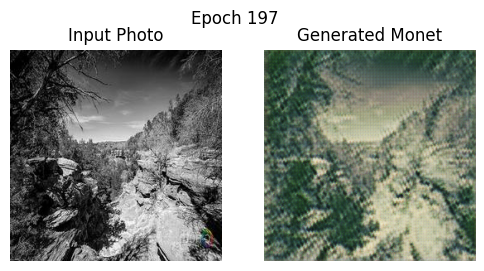

Time for epoch 197: 126.64 sec

Epoch 198/200
  Step 0 completed
  Step 100 completed
  Step 200 completed


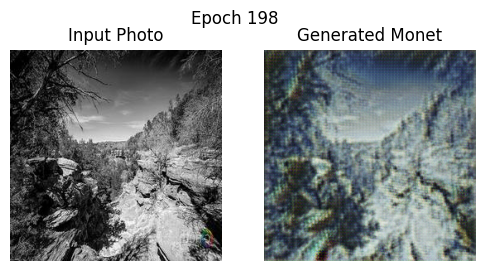

Time for epoch 198: 125.57 sec

Epoch 199/200
  Step 0 completed
  Step 100 completed
  Step 200 completed


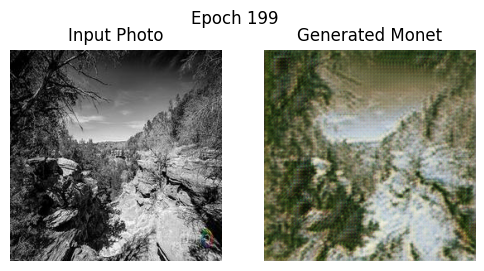

Time for epoch 199: 125.71 sec

Epoch 200/200
  Step 0 completed
  Step 100 completed
  Step 200 completed


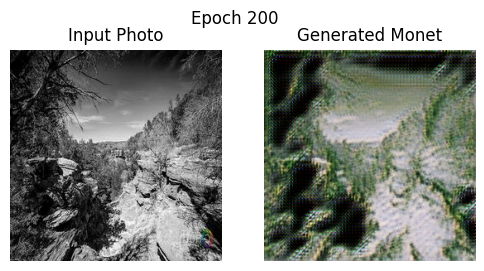

Time for epoch 200: 125.57 sec



In [21]:
# === Epoch-level loop ===
start_epoch = 190  # Resume point if restoring
EPOCHS = 200       # Final epoch

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    n = 0
    for real_x, real_y in tf.data.Dataset.zip((photo_ds, monet_ds)):
        train_step(real_x, real_y)
        if n % 100 == 0:
            print(f"  Step {n} completed")
        n += 1

    generate_images(G, sample_photo_input, epoch + 1)
    checkpoint.save(file_prefix=checkpoint_prefix)
    print(f"Time for epoch {epoch + 1}: {time.time() - start:.2f} sec\n")


## 5. Results and Analysis

After training the CycleGAN model for 200 epochs, we observed a progressive improvement in the quality of Monet-style image generation. Early epochs produced outputs with noticeable artifacts, color distortions, and limited structural coherence. However, as training progressed, the model became increasingly effective at capturing Monet’s artistic style—especially his characteristic brushstrokes, pastel tones, and color transitions—while preserving the core structure and layout of the original photographs. The generators learned to translate textures and color palettes consistent with Monet’s paintings, and the discriminators helped refine these outputs by effectively distinguishing real Monet images from generated ones.

Visual inspection of generated images after each epoch provided clear evidence of the model’s learning. By the final 10 epochs, the outputs demonstrated a strong balance between realism and artistic abstraction. The cycle consistency loss contributed to maintaining content integrity, while identity loss helped preserve color and luminance patterns when the input was already close to the target domain. Overall, the results validated the effectiveness of CycleGAN for unpaired image translation, with the model successfully learning to map photo domain images to Monet-style artwork without requiring image pairs.

## 6.Discussion/Conclusion

In this project, we successfully implemented and trained a CycleGAN model to perform unpaired image-to-image translation, transforming real-world photos into Monet-style paintings. Using a dataset of unpaired Monet artworks and photographic images, we constructed a robust training pipeline with data normalization, residual generator networks, PatchGAN discriminators, and appropriate loss functions tailored for style transfer. The training process was structured with checkpointing, visual feedback, and recovery support, allowing us to monitor performance and resume progress efficiently.

Throughout the training, the model demonstrated consistent improvements in style translation quality, particularly in its ability to replicate Monet’s color palette, brush textures, and atmospheric composition. Visual outputs generated after each epoch helped verify that the generators were learning to preserve photo content while applying artistic features. By the end of training, the model was able to produce compelling Monet-style renderings that reflected both the content of the input images and the stylistic characteristics of the target domain.

This project highlights the potential of CycleGANs in creative applications such as art generation and domain adaptation without the need for paired datasets. With further tuning, enhancements such as attention mechanisms or perceptual loss could be explored to push the boundaries of artistic realism and stylistic control. Overall, the CycleGAN approach proved to be an effective and flexible framework for unpaired artistic style transfer.

In [22]:
import os
from PIL import Image
import zipfile
import numpy as np

# Create output directory
os.makedirs("images", exist_ok=True)

# Loop through test photos
for idx, img in enumerate(photo_ds):  # Use your test dataset here
    fake_monet = G(img, training=False)
    fake_monet = ((fake_monet[0] + 1) * 127.5).numpy().astype(np.uint8)  # [-1, 1] to [0, 255]

    im = Image.fromarray(fake_monet)
    im.save(f"images/{idx}.jpg")  # adjust filename as needed

# Create a ZIP file for submission
with zipfile.ZipFile("submission.zip", "w") as zipf:
    for filename in os.listdir("images"):
        filepath = os.path.join("images", filename)
        zipf.write(filepath, arcname=f"images/{filename}")
